## Link to github repository
https://github.com/Rusamus/Neural-machine-translation-hw.git

### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на github с проектом - 

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
import sys
sys.path.insert(0, '/raid/visionlab/Neural-machine-translation-hw/src')

In [2]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models import trainer
import os

## freeze seed & define boilerplate

In [3]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = TXTLogger("baseline")

## prepare data

In [4]:
with open("configs/data_config.yaml", "r") as fread:
    data_config = yaml.load(fread, Loader=yaml.Loader)

data_manager = DataManager(data_config, device)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer


Reading from file: 100%|██████████| 467119/467119 [00:06<00:00, 70463.82it/s]


## prepare model

In [5]:
with open("configs/model_config.yaml", "r") as fread:
    model_config = yaml.load(fread, Loader=yaml.Loader)

model_config["src_vocab_size"] = data_manager.source_tokenizer.tokenizer.get_vocab_size()
model_config["tgt_vocab_size"] = data_manager.target_tokenizer.tokenizer.get_vocab_size()
model_config["T_max"] = model_config["epoch_num"] * len(train_dataloader)
model_config["device"] = device 
model = Seq2SeqTransformer(model_config, target_tokenizer.word2index).to(device)

In [6]:
model_config

{'embedding_size': 300,
 'hidden_size': 100,
 'epoch_num': 200,
 'nhead': 4,
 'num_encoder_layers': 4,
 'lr': 5e-05,
 'weight_decay': 0.0005,
 'maxlen': 15,
 'src_vocab_size': 2703,
 'tgt_vocab_size': 4313,
 'T_max': 1000,
 'device': device(type='cuda')}

In [7]:
# train_one_batch = True
# if train_one_batch:
#     train_dataloader = [list(train_dataloader)[0]]
#     val_dataloader = [list(val_dataloader)[0]]

In [8]:
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=target_tokenizer
)

trainer_cls.train(train_dataloader, val_dataloader)

  0%|          | 0/200 [00:00<?, ?it/s]/raid/visionlab/python/miniconda3/envs/test/lib/python3.8/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 42%|████▏     | 84/200 [01:01<01:25,  1.36it/s]

Last 84 epoch train loss:  0
Last 84 epoch val loss:  2.935237169265747
Last 84 epoch val bleu:  0.009574999411900839


## plot training progress

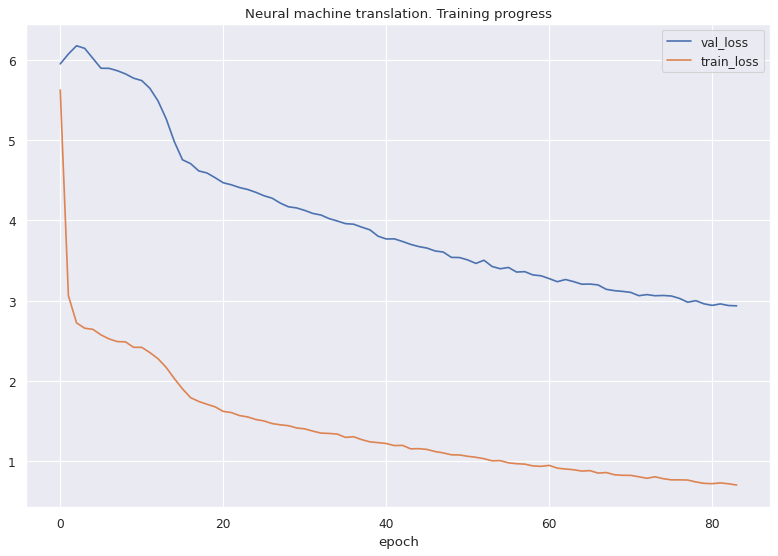

In [9]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import ast

with open("./baseline/progress_log.txt", 'r') as fread:
    stats = fread.readlines()
sns.lineplot
val_loss, train_loss, bleu_score = [], [], []
for i in range(1, len(stats)):
    stats[i] = ast.literal_eval(stats[i])
    val_loss.append(stats[i]['val_loss'])
    train_loss.append(stats[i]['train_loss'])
    bleu_score.append(stats[i]['bleu_score'])

sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(val_loss)), val_loss, label='val_loss')
sns.lineplot(np.arange(len(train_loss)), train_loss, label='train_loss')
plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

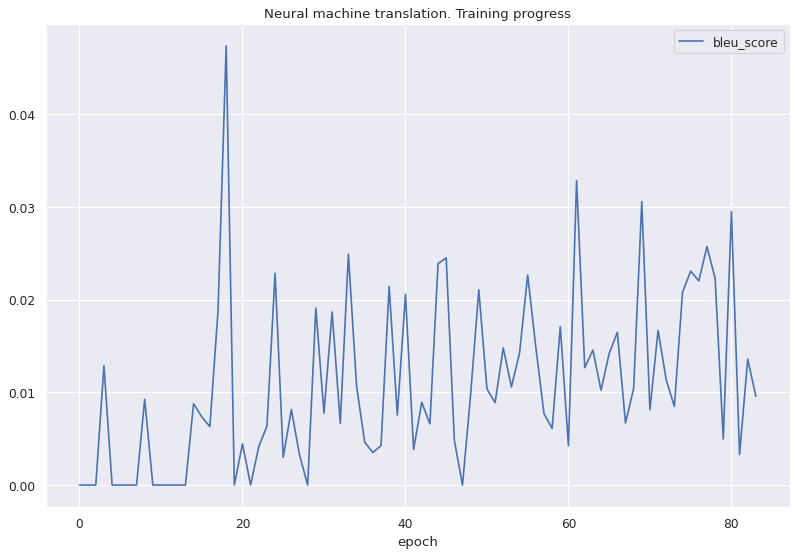

In [10]:
sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(bleu_score)), bleu_score, label='bleu_score')

plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

#### Графики обучения и валидации выходят на плато. Переобучение модели

## generate examples of translation

In [11]:
batch = next(iter(val_dataloader))
inp, tgt = batch[0][:10], batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)

for i in range(10):
    src_decoded = " ".join(data_manager.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(data_manager.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(data_manager.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"EN: {src_decoded}\nRU: {tgt_decoded}\nPRED: {out_decoded}")
    print('>>>>>>>>>')


EN: s h e   i s   b y   f a r   t h e   b e s t   p l a y e r   i n   t h e   c l u b
RU: о н а   б е з у с л о в н о   л у ч ш и й   и г р о к   в   к л у   б е
PRED: р а й   о п ы   н и с т   ж е с т в а   б л а г о р а з у м н а   в з р о с л ы й   п р и в я з а н   к о м п о з и т о р   м и л а я   ф у т б о л   з а с т р а   в е д ь   д е й с т в и т е л ь   д л я   а л к о г о л и к
>>>>>>>>>
EN: s h e   s   s u f f e r i n g   f r o m   a   s e r i o u s   d i s   e a s e
RU: о н а   с т р а д а е т   и з   з а   т я ж   ё   л о   г о   з а   б о л е   в а н и я
PRED: т ы в а е т   г о т о в и т ь   м е н я   м е н я   м е н я   м е н я   м е н я   м е н я   м е н я   с а м ы й   м е н я   м е н я   м е н я   т о к и   м е н я
>>>>>>>>>
EN: s h e   i s   c o m p l e t e l y   d e a f   i n   h e r   l e f t   e a r
RU: о н а   п о л   н о с т ь ю   г л у х а   н а   л е   в о   е   у   х о
PRED: б е з у м е н   н е п р а в а   а п п е т   т я ж е л ы й
>>>>>>>>>
EN: h e   s   a 

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [22]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_t5 import Seq2SeqT5
from src.models import trainer

In [27]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = TXTLogger("baseline_t5")


In [28]:
with open("configs/t5_data_config.yaml", "r") as fread:
    data_config = yaml.load(fread, Loader=yaml.Loader)

data_manager = DataManager(data_config, device)
train_dataloader, val_dataloader = data_manager.prepare_data()

Reading from file: 100%|██████████| 467119/467119 [00:06<00:00, 70071.54it/s]


In [29]:
with open("configs/t5_model_config.yaml", "r") as fread:
    model_config = yaml.load(fread, Loader=yaml.Loader)

model_config["device"] = device 
model_config["tokenizer_length"] = data_config["tokenizer_length"]
model = Seq2SeqT5(model_config).to(device)

In [30]:
model_config

{'embedding_size': 100,
 'hidden_size': 100,
 'epoch_num': 100,
 'lr': 0.0003,
 'maxlen': 15,
 'device': device(type='cuda'),
 'tokenizer_length': 32100}

In [31]:
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=data_config["tokenizer"]
    )

trainer_cls.train(train_dataloader, val_dataloader)

  8%|▊         | 8/100 [00:20<03:51,  2.51s/it]

Last 8 epoch train loss:  9.014099359512329
Last 8 epoch val loss:  1.8143351078033447
Last 8 epoch val bleu:  0.24883644285728224


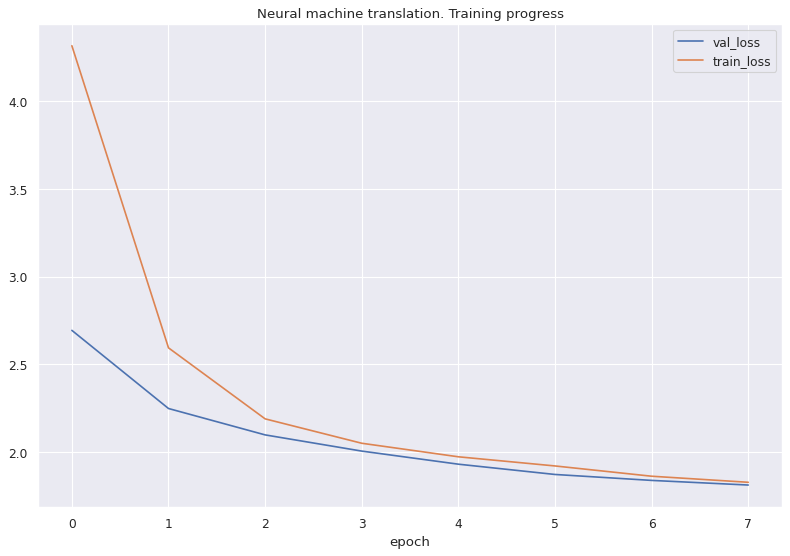

In [32]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import ast

with open("./baseline_t5/progress_log.txt", 'r') as fread:
    stats = fread.readlines()
sns.lineplot
val_loss, train_loss, bleu_score = [], [], []
for i in range(1, len(stats)):
    stats[i] = ast.literal_eval(stats[i])
    val_loss.append(stats[i]['val_loss'])
    train_loss.append(stats[i]['train_loss'])
    bleu_score.append(stats[i]['bleu_score'])

sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(val_loss)), val_loss, label='val_loss')
sns.lineplot(np.arange(len(train_loss)), train_loss, label='train_loss')
plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

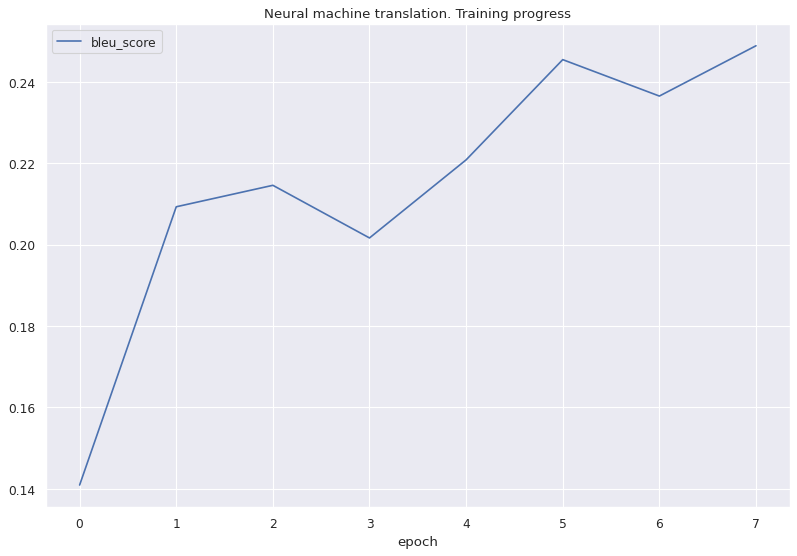

In [33]:
sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(bleu_score)), bleu_score, label='bleu_score')

plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

In [64]:
def clean_prediction(prediction: str) -> str:
    cleaned_text = prediction.replace("< p a d >", "").replace("< u n k >", "").replace("< / s >", "")
    cleaned_text = ' '.join(cleaned_text.split())
    
    return cleaned_text

In [69]:
batch = next(iter(val_dataloader))
inp, tgt = batch[0][:10], batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)

for i in range(10):
    src_decoded = " ".join(data_manager.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(data_manager.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(data_manager.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"EN: {src_decoded}\nRU: {clean_prediction(tgt_decoded)}\nPRED: {clean_prediction(out_decoded)}")
    print('>>>>>>>>>')

EN: h e   i s   n o t   t h e   s h y   b o y   h e   u s e d   t o   b e < / s > < p a d > < p a d >
RU: о н у е н е т о т а
PRED: о н о р о о о и
>>>>>>>>>
EN: h e   i s   l a t e   f o r   m e e t i n g s   n i n e   t i m e s   o u t   o f   t e n < / s > < p a d > < p a d >
RU: о н о а д в а е т н а в
PRED: о н о р о о о р о о
>>>>>>>>>
EN: h e   s   q u i t e   a   n i c e   f e l l o w   b u t   i   d o n   < / s >
RU: о н о р о и а р е н
PRED: о р о о о е н
>>>>>>>>>
EN: s h e   i s   b u s y   r i g h t   n o w   a n d   s h e   c a n   t   s p e a k   w i t h   y o u < / s > < p a d >
RU: р м о с е а с о н а
PRED: о о е о
>>>>>>>>>
EN: s h e   i s   l o o k i n g   f o r w a r d   t o   h e r   b i r t h d a y   p a r t y < / s > < p a d > < p a d > < p a d > < p a d > < p a d > < p a d >
RU: о н а с н е т е р е н и е м д
PRED: о а и а
>>>>>>>>>
EN: h e   i s   s t r a n g e   a n d   i   d o n   t   l i k e   s t r a n g e   p e o p l e < / s > < p a d >
RU: о н с т р а н н 